In [182]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 2.8 MB/s eta 0:00:0000:0100:01
  Using cached altair-5.4.1-py3-none-any.whl (658 kB)
  Using cached blinker-1.8.2-py3-none-any.whl (9.5 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl (9.5 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.7/414.7 kB 3.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.2/27.2 MB 5.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.1/242.1 kB 5.3 MB/s eta 0:00:00a 0:00:01
  Using cached toml-0.10.2-py2.py3-none-any.whl (16 kB)
  Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
  Using cached pydeck-0.9.1-py2.py3-none-any.whl (6.9 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.3/185.3 kB 6.0 MB/s eta 0:00:00
  Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 3.7 MB/s eta 0:00:00
  Using cached smmap-5.0.1-py3-none-any.whl (24 kB)

[notice] A new release of pip is ava

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  1 of 1 completed
AAPL    0.185332
CAT     0.878632
MSFT    0.578955
TSLA    0.110291
WMT    -0.753210
dtype: float64


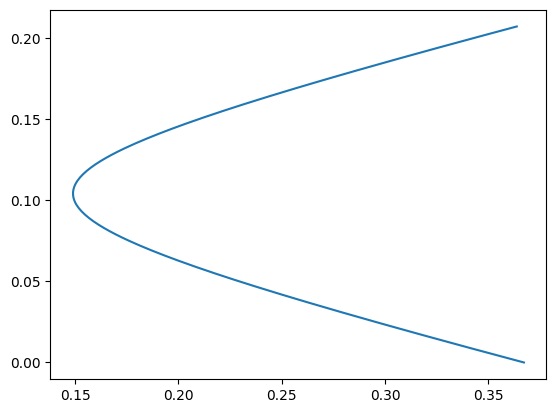

In [100]:
import numpy as np
import pandas as pd
import yfinance as yf
from dateutil.relativedelta import relativedelta

# Merton Matrix Model - Min Variance Portfolio

# Timeframe

sd = pd.Timestamp('2010-01-01').date()
ed = pd.Timestamp('2020-01-01').date()

if relativedelta(ed,sd).days >0 and relativedelta(ed,sd).years <1:
    time_frame = 1
else:
    time_frame = relativedelta(ed,sd).years


# choose stocks

stocks_ = ['TSLA', 'AAPL', 'MSFT', 'WMT', 'CAT']
mkt_ = ['^GSPC']
data = yf.download(stocks_, start=sd, end=ed)
mkt_data = yf.download(mkt_, start = sd, end = ed)

# data treatment

ticker = '^TNX'
risk_free_data = yf.Ticker(ticker).history(period=f'{time_frame}y')

rf = risk_free_data['Close'].mean()/100

rf
from dateutil.relativedelta import relativedelta

relativedelta(ed,sd).years
data = data['Adj Close']

if data.isna().sum().sum() > 0.1*len(data):
    raise AssertionError
else:
    data = data.dropna()

stock_returns = data.pct_change().dropna()
df_statistics = pd.DataFrame()
df_statistics['Return'] = (stock_returns + 1).prod()**(252/len(stock_returns))-1
df_statistics['Std'] = stock_returns.std() * np.sqrt(252)
mkt_returns = mkt_data['Adj Close'].pct_change().dropna()
mkt_returns = mkt_returns.reindex(mkt_returns.index.intersection(stock_returns.index))
sp = (mkt_returns+1).product()**(252/len(mkt_returns))-1

beta_ = {}
for i in stock_returns:
    y = np.array(stock_returns[i]).reshape(-1, 1)  # Dependent variable (stock returns)
    X = np.array(mkt_returns).reshape(-1, 1)  # Independent variable (market returns)
    
    # Adds a column for the intercept (constant term)
    X = np.hstack((np.ones((len(X), 1)), X))  
    beta_[i] = np.linalg.inv(X.T @ X) @ (X.T @ y)

beta_only = {stock: coeff[1] for stock, coeff in beta_.items()}

beta_df = pd.DataFrame(list(beta_only.values()), index=beta_only.keys(), columns=['Beta'])
df_statistics['beta'] = beta_df
df_statistics = df_statistics.T
er = {}
for i in df_statistics:
    er[i] = rf + df_statistics.loc['beta', i] * (sp - rf)
df_statistics.loc['Expected Return(CAPM)'] = er.values()
stock_cov = stock_returns.cov()*252
stock_cov_inv = np.linalg.inv(stock_cov)
stock_cov_inv = pd.DataFrame(stock_cov_inv)
stock_cov_inv.columns = stock_cov.columns
e_ = [1]*len(stock_cov.columns)
r_ = list(df_statistics.loc['Expected Return(CAPM)'])
h_ = np.matmul(e_, stock_cov_inv)
g_ = np.matmul(r_, stock_cov_inv)
alpha = np.matmul(e_, h_.T)
beta = np.matmul(e_, g_.T)
gamma = np.matmul(r_, g_.T)
delta = alpha*gamma - beta**2
MVP = h_/alpha
pf_return = beta/alpha
pf_std = np.sqrt(1/alpha)
import matplotlib.pyplot as plt
risk_ = {}
x = []
for j in range(0,int(np.round(pf_return,3)*2000), 1):
    risk_[j] = np.sqrt((alpha*((j/1000)**2)-2*beta*(j/1000) + gamma)/delta)
    x.append(j/1000)
plt.plot(risk_.values(), x)

target_return = 0.2

lambda_ = (gamma - beta*target_return)/delta
mew_ = (alpha*target_return - beta)/delta

optimal_pf = lambda_ * h_ + mew_ * g_

print(optimal_pf)


In [176]:
# BLACK LITTERMAN
from datetime import timedelta

caps = {}

for i in stocks_:
    ticker = yf.Ticker(i)
    all_dates = ticker.quarterly_income_stmt.columns
    total_shares = ticker.quarterly_income_stmt[all_dates[0]]['Basic Average Shares']
    stock_price = ticker.history(start=all_dates[0]-timedelta(2,0,0), end=all_dates[0])['Close']
    market_cap = stock_price * total_shares
    caps[i] = (market_cap.values[0])
market_caps = caps


In [177]:
total_cap = sum(market_caps.values())
df = pd.DataFrame(market_caps.items(), columns=['Stock', 'Market Cap'])
df['Cap Ratio'] = df['Market Cap'] / total_cap
mkt_cap_weights = df['Cap Ratio'].values
mkt_cap_weights

array([0.08009241, 0.40794057, 0.42063331, 0.0708325 , 0.02050121])

In [178]:
from scipy.optimize import minimize

initial_r = r_
def objective_function(r):
    # Calculate h_ and g_ based on adjusted r_
    h_ = np.matmul(e_, stock_cov_inv)
    g_ = np.matmul(r, stock_cov_inv)
    alpha = np.matmul(e_, h_.T)
    beta = np.matmul(e_, g_.T)
    gamma = np.matmul(r, g_.T)
    delta = alpha * gamma - beta**2

    # Calculate optimal portfolio weights
    target_return = (gamma - beta*rf)/(beta-alpha*rf)
    lambda_ = (gamma - beta * rf) / delta
    mew_ = (alpha * target_return - beta) / delta
    optimal_pf = lambda_ * h_ + mew_ * g_

    # Return the difference from market cap weights
    return np.sum((optimal_pf - mkt_cap_weights) ** 2)

result = minimize(objective_function, initial_r, method='L-BFGS-B')

# Updated expected returns after optimization
optimized_r = result.x

In [179]:
optimized_r

array([-0.00823814, -0.02530273, -0.01664642, -0.02841783,  0.01111734])

In [180]:
r_

[0.1293448226706741,
 0.15979238182358396,
 0.135391744633012,
 0.1559184283715318,
 0.07959595589068968]